# Exploratory Data Analysis

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

pd.set_option("display.max_rows", 200)

## Train data

In [2]:
# Loading the original data

data_train = pd.read_csv(
    "../data/train/train_features_sent.csv", index_col="level_0", low_memory=False
)
labels_train = pd.read_csv(
    "../data/train/train_labels_sent.csv", index_col="level_0", low_memory=False
)

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010684 entries, 111323 to 31221
Data columns (total 70 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   additional_heat_generators        1010684 non-null  object 
 1   additional_water_heaters          209994 non-null   object 
 2   altitude                          992545 non-null   float64
 3   area_code                         1010684 non-null  int64  
 4   balcony_depth                     105791 non-null   object 
 5   bearing_wall_material             956635 non-null   object 
 6   building_category                 1010684 non-null  object 
 7   building_class                    1010684 non-null  object 
 8   building_height_ft                994468 non-null   float64
 9   building_period                   1010684 non-null  object 
 10  building_total_area_sqft          949721 non-null   float64
 11  building_type                     

In [4]:
n_samples, n_features = data_train.shape

In [5]:
data_train.head()

,additional_heat_generators,additional_water_heaters,altitude,area_code,balcony_depth,bearing_wall_material,building_category,building_class,building_height_ft,building_period,...,wall_insulation_type,water_heaters,water_heating_energy_source,water_heating_type,window_filling_type,window_frame_material,window_glazing_type,window_heat_retention_factor,window_orientation,window_thermal_conductivity
level_0,,,,,,,,,,,,,,,,,,,,,
111323,[wood stove or insert],NaN,328.08400,881,NaN,CONCRETE,[],[],13.779528,1970-1988,...,internal,[indeterminate oil boiler],oil,individual,argon or krypton,pvc,double glazing,1.116894,"[est,west]",15.347292
265182,[],NaN,360.89240,260,NaN,NaN,[condo],[2 to 11],43.635172,<1948,...,internal,[indeterminate gas boiler],gas,individual,argon or krypton,wood,double glazing,1.133072,"[est,west,sud]",17.512631
927507,[],NaN,324.80316,573,NaN,WOOD - OTHER,[],[],19.685040,2000-2005,...,internal,[standard gas boiler],gas,individual,dry air,pvc,double glazing,1.084204,"[est,west]",16.779108
874620,[],NaN,288.71392,204,NaN,BRICKS,[],[],13.779528,<1948,...,internal,[electric storage tank],electricity,individual,NaN,metal with thermal break,triple glazing,0.983338,"[est,north,sud]",12.630033
563274,[],NaN,849.73756,374,NaN,GRITSTONE,[individual house],[individual],19.028872,2006-2012,...,internal,[thermodynamic electric hot water (pac or tank)],thermodynamic electric hot water (heat pump or...,individual,dry air,pvc,double glazing,1.084204,"[north,sud]",13.290529


We can look at columns with lot of NaN values. If a column lacks too many observations, it might be wise to just remove it.

In [6]:
data_train.columns[data_train.isnull().sum() > 0.3 * n_samples]

Index(['additional_water_heaters', 'balcony_depth', 'nb_commercial_units',
       'nb_gas_meters_commercial', 'nb_gas_meters_housing',
       'nb_gas_meters_total', 'nb_housing_units', 'nb_meters',
       'nb_parking_spaces', 'nb_power_meters_commercial',
       'nb_power_meters_housing', 'nb_power_meters_total', 'nb_units_total',
       'renewable_energy_sources'],
      dtype='object')

## Labels

In [7]:
y_train = labels_train.squeeze()

In [8]:
labels_train.head()

,energy_consumption_per_annum
level_0,
111323,290.166345
265182,169.818197
927507,144.499711
874620,158.742715
563274,82.223648


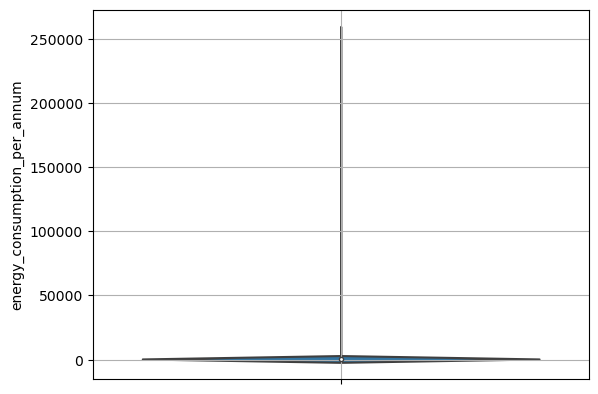

In [9]:
sns.violinplot(y=y_train)
plt.grid()
plt.show()

We observe abnormally high $y$ values in the dataset. They are potential outliers of the dataset, so it might be better to remove the rows for training.

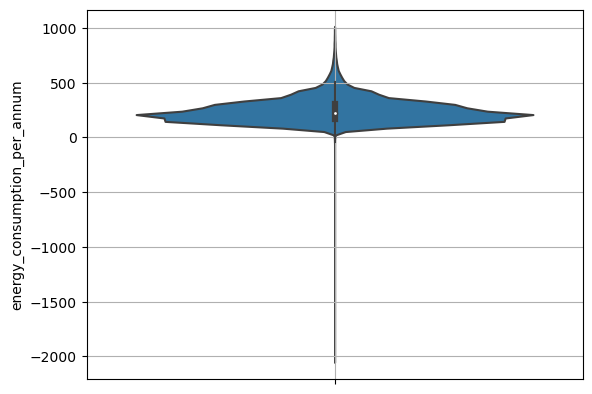

In [10]:
sns.violinplot(y=y_train[y_train < 1000])
plt.grid()
plt.show()

There are also rows with negative $y$ values, which hardly makes sense because energy consumption is supposed to be a positive real number.

In [11]:
# Checking rows with overly high values of y.
labels_train[labels_train["energy_consumption_per_annum"] > 50000]

,energy_consumption_per_annum
level_0,
1444968,202104.169584
1444427,259423.487953
1444963,202092.928662
1402162,259424.532746
1444443,179923.742340
1444429,259432.810130
1444436,259429.471116
1444435,259425.659104
1444422,202093.628547


In [12]:
# Checking rows with negative values of y.
y_negative = labels_train < 0
y_negative.sum()

energy_consumption_per_annum    142
dtype: int64

We can once again look at an overview of the train dataset without said outliers.

In [13]:
y_train_ = labels_train[(y_train > 0) & (y_train < 50000)]

In [14]:
X_train_ = data_train[(y_train > 0) & (y_train < 50000)]

In [15]:
X_train_.describe()

,altitude,area_code,building_height_ft,building_total_area_sqft,building_use_type_code,building_year,living_area_sqft,lowe_floor_thermal_conductivity,nb_commercial_units,nb_dwellings,...,nb_power_meters_commercial,nb_power_meters_housing,nb_power_meters_total,nb_units_total,outer_wall_thermal_conductivity,percentage_glazed_surfaced,post_code,upper_floor_thermal_conductivity,window_heat_retention_factor,window_thermal_conductivity
count,992393.000000,1.010530e+06,994315.000000,949573.000000,1.010530e+06,951083.000000,1.010518e+06,933233.000000,116103.000000,1.010530e+06,...,95212.000000,95212.000000,95212.000000,116103.000000,1.003174e+06,882379.000000,1.010530e+06,964742.000000,988175.000000,1.005425e+06
mean,453.938899,5.175515e+02,20.006823,1642.562595,1.227824e+00,1973.980290,1.227656e+03,3.308640,16.903494,4.914423e+00,...,0.083703,26.060356,25.513623,104.103535,4.688165e+00,0.827723,5.102472e+07,2.237687,1.247056,1.714528e+01
std,513.080802,2.387942e+02,12.960359,1963.808347,5.607512e-01,38.922053,2.494995e+03,0.720957,91.572329,2.000626e+01,...,0.465806,44.427683,44.206385,317.414105,3.063513e+00,0.176225,2.427379e+07,0.852130,0.569521,5.779699e+00
min,-9.842520,1.090000e+02,0.000000,64.583400,1.000000e+00,1200.000000,0.000000e+00,2.282947,0.000000,1.000000e+00,...,0.000000,0.000000,0.000000,0.000000,1.088024e+00,0.310000,1.000122e+07,1.488072,0.243582,2.780761e+00
25%,124.671920,3.040000e+02,12.795276,882.639800,1.000000e+00,1964.000000,7.965286e+02,2.797533,0.000000,1.000000e+00,...,0.000000,6.757500,6.440000,12.000000,2.447516e+00,0.720170,3.034212e+07,1.770545,1.084204,1.396372e+01
50%,295.275600,5.200000e+02,17.060368,1205.556800,1.000000e+00,1979.000000,1.022571e+03,2.844251,0.000000,1.000000e+00,...,0.000000,15.000000,15.000000,32.000000,2.944443e+00,0.786523,5.048903e+07,1.890570,1.133072,1.605727e+01
75%,597.112880,7.040000e+02,22.637796,1646.876700,1.000000e+00,1999.000000,1.334724e+03,4.070746,8.000000,1.000000e+00,...,0.000000,30.000000,29.000000,87.000000,5.515635e+00,0.886707,7.200292e+07,2.201487,1.212343,1.901402e+01
max,6167.979200,9.520000e+02,511.811040,230444.335100,5.000000e+00,2019.000000,3.815157e+05,5.960612,10874.000000,4.994000e+03,...,35.000000,4463.000000,4490.230000,42317.350000,2.652868e+01,1.998632,9.992662e+07,5.547723,15.891206,2.122490e+02


## Test data

In [17]:
data_test = pd.read_csv(
    "../data/test/test_features_sent.csv", index_col="level_0", low_memory=False
)
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 494940 entries, 1371914 to 587391
Data columns (total 70 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   additional_heat_generators        494940 non-null  object 
 1   additional_water_heaters          102795 non-null  object 
 2   altitude                          486119 non-null  float64
 3   area_code                         494940 non-null  int64  
 4   balcony_depth                     51624 non-null   object 
 5   bearing_wall_material             469002 non-null  object 
 6   building_category                 494940 non-null  object 
 7   building_class                    494940 non-null  object 
 8   building_height_ft                487056 non-null  float64
 9   building_period                   494940 non-null  object 
 10  building_total_area_sqft          465336 non-null  float64
 11  building_type                     494940 non-n

# Feature importances

Without preprocessing, we can visualize the importance of numeric features only, to get a rough idea which numerical features are important. Note that this is only an indicative reference.

We can do so by trying to fit a Random Forest model. To accelerate training, we subsample the dataset.

In [18]:
# Only use numerical data

numerics = ["float16", "float32", "float64"]
X_train_numeric = X_train_.select_dtypes(include=numerics)
column_names = np.array(X_train_numeric.columns)

In [19]:
X_train_numeric.head()

,altitude,building_height_ft,building_total_area_sqft,building_year,living_area_sqft,lowe_floor_thermal_conductivity,nb_commercial_units,nb_gas_meters_commercial,nb_gas_meters_housing,nb_gas_meters_total,...,nb_parking_spaces,nb_power_meters_commercial,nb_power_meters_housing,nb_power_meters_total,nb_units_total,outer_wall_thermal_conductivity,percentage_glazed_surfaced,upper_floor_thermal_conductivity,window_heat_retention_factor,window_thermal_conductivity
level_0,,,,,,,,,,,,,,,,,,,,,
111323,328.08400,13.779528,1291.6680,1979.0,904.1676,2.844251,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.364981,0.847969,2.078260,1.116894,15.347292
265182,360.89240,43.635172,7136.4657,NaN,785.7647,4.498072,0.0,NaN,NaN,NaN,...,450.0,NaN,NaN,NaN,1122.0,3.364592,0.750366,2.078260,1.133072,17.512631
927507,324.80316,19.685040,4197.9210,1810.0,1162.5012,2.813221,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.447516,NaN,1.790967,1.084204,16.779108
874620,288.71392,13.779528,1646.8767,1972.0,1937.5020,2.749757,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.819698,0.748615,1.811218,0.983338,12.630033
563274,849.73756,19.028872,1033.3344,2012.0,1087.1539,2.684326,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.508377,0.662147,1.770545,1.084204,13.290529


In [20]:
from sklearn.impute import SimpleImputer

X_train_imputed = SimpleImputer().fit_transform(X_train_numeric, y_train)

In [21]:
# Subsample dataset
rng = np.random.RandomState(seed=42)

n_subsamples = X_train_imputed.shape[0] // 10

idx = rng.choice(X_train_imputed.shape[0], size=n_subsamples, replace=False)

In [22]:
# Fit a RF
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_imputed[idx], y_train_.squeeze().iloc[idx])

RandomForestRegressor()

In [23]:
# Retrieve feature importances
rf_reg.feature_importances_

array([0.06333677, 0.04903597, 0.03856507, 0.05908574, 0.09178192,
       0.03304986, 0.00206087, 0.00575282, 0.04258034, 0.03593066,
       0.00288107, 0.00672535, 0.00237126, 0.00113813, 0.00166336,
       0.00486044, 0.00273298, 0.13682402, 0.3020811 , 0.03561977,
       0.05019   , 0.03173252])

In [24]:
# Sort feature importances and retrieve corresponding indices.
sorted_idx = np.argsort(rf_reg.feature_importances_)

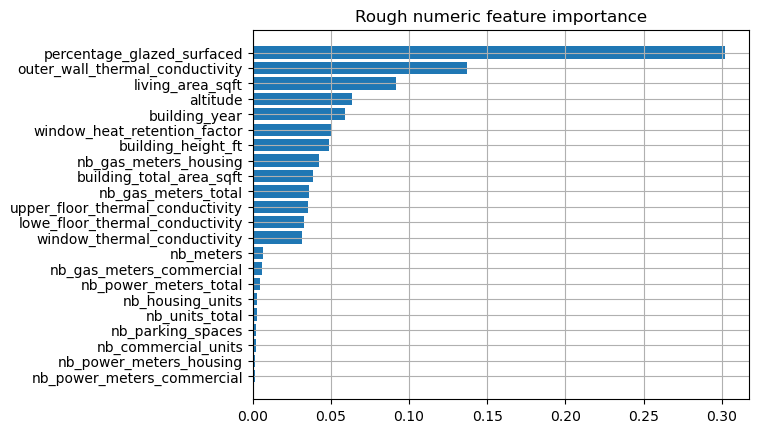

In [25]:
# Plot feature importances for better visualization
plt.figure()
plt.grid()
plt.barh(column_names[sorted_idx], rf_reg.feature_importances_[sorted_idx])
plt.title("Rough numeric feature importance")
plt.show()

Pretty consistent, given that:
- conductivity is directly correlated to isolation, thus energy consumption
- glazed surface is indirectly correlated to isolation as well, thus energy consumption.
- the surface (or general geometry) of the building and altitude somewhat impacts the needs for heating.